In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ESRNN import ESRNN
plt.style.use('ggplot')
pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

In [2]:
# Plot
def plot_prediction(y, y_hat):
    n_y = len(y)
    n_yhat = len(y_hat)
    ds_y = np.array(range(n_y))
    ds_yhat = np.array(range(n_y-n_yhat, n_y))

    plt.plot(ds_y, y, label = 'y')
    plt.plot(ds_yhat, y_hat, label='y_hat')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def ffill_missing_dates_particular_serie(serie, min_date, max_date, freq):
    date_range = pd.date_range(start=min_date, end=max_date, freq=freq)
    unique_id = serie['unique_id'].unique()
    df_balanced = pd.DataFrame({'ds':date_range, 'key':[1]*len(date_range), 'unique_id': unique_id[0]})

    # Check balance
    check_balance = df_balanced.groupby(['unique_id']).size().reset_index(name='count')
    assert len(set(check_balance['count'].values)) <= 1
    df_balanced = df_balanced.merge(serie, how="left", on=['unique_id', 'ds'])

    df_balanced['y'] = df_balanced['y'].fillna(method='ffill')

    return df_balanced

def ffill_missing_dates_per_serie(df, freq, fixed_max_date=None):
    """Receives a DataFrame with a date column and forward fills the missing gaps in dates, not filling dates before
    the first appearance of a unique key

    Parameters
    ----------
    df: DataFrame
        Input DataFrame
    key: str or list
        Name(s) of the column(s) which make a unique time series
    date_col: str
        Name of the column that contains the time column
    freq: str
        Pandas time frequency standard strings, like "W-THU" or "D" or "M"
    numeric_to_fill: str or list
        Name(s) of the columns with numeric values to fill "fill_value" with
    """
    if fixed_max_date is None:
        df_max_min_dates = df[['unique_id', 'ds']].groupby('unique_id').agg(['min', 'max']).reset_index()
    else:
        df_max_min_dates = df[['unique_id', 'ds']].groupby('unique_id').agg(['min']).reset_index()
        df_max_min_dates['max'] = fixed_max_date

    df_max_min_dates.columns = df_max_min_dates.columns.droplevel()
    df_max_min_dates.columns = ['unique_id', 'min_date', 'max_date']

    df_list = []
    for index, row in df_max_min_dates.iterrows():
        df_id = df[df['unique_id'] == row['unique_id']]
        df_id = ffill_missing_dates_particular_serie(df_id, row['min_date'], row['max_date'], freq)
        df_list.append(df_id)

    df_dates = pd.concat(df_list).reset_index(drop=True).drop('key', axis=1)[['unique_id', 'ds', 'y']]

    return df_dates

# Train

In [4]:
data = pd.read_csv('data/terra/train.csv')

In [5]:
data = pd.read_csv('data/terra/train.csv')
data['ds'] = pd.to_datetime(data['day'], unit='d')
data['unique_id'] = data['cultivar'] + data['sitename']
data = data.rename(columns={'canopy_height':'y'})

#Series must be complete in the frequency
data = ffill_missing_dates_per_serie(data,'D')
data = data.drop_duplicates(['unique_id','ds'])

data.head()

,unique_id,ds,y
0,PI145619MAC Field Scanner Season 4 Range 27 Co...,1970-01-13,10.0
1,PI145619MAC Field Scanner Season 4 Range 27 Co...,1970-01-14,10.0
2,PI145619MAC Field Scanner Season 4 Range 27 Co...,1970-01-15,10.0
3,PI145619MAC Field Scanner Season 4 Range 27 Co...,1970-01-16,10.0
4,PI145619MAC Field Scanner Season 4 Range 27 Co...,1970-01-17,10.0


In [6]:
X_train = data[['unique_id','ds']]
X_train['x'] = '1'
y_train = data[['unique_id','ds','y']]

/Users/cchallu/anaconda3/envs/esrnn_torch/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


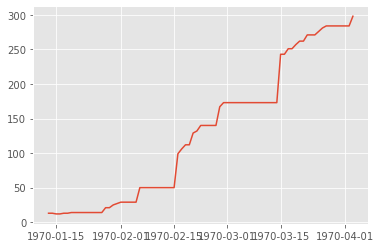

In [7]:
data_plot = y_train[y_train['unique_id']=='PI157030MAC Field Scanner Season 4 Range 17 Column 14']
plt.plot(data_plot['ds'], data_plot['y'], label = 'y')
plt.show()

# Test

In [8]:
data_test = pd.read_csv('data/terra/test_real.csv')
data_test['ds'] = pd.to_datetime(data_test['day'], unit='d')
data_test['unique_id'] = data_test['cultivar'] + data_test['sitename']
data_test.head()

,d3mIndex,cultivar,sitename,day,canopy_height,ds,unique_id
0,34,PI145619,MAC Field Scanner Season 4 Range 27 Column 11,133,341,1970-05-14,PI145619MAC Field Scanner Season 4 Range 27 Co...
1,69,PI145619,MAC Field Scanner Season 4 Range 27 Column 12,133,336,1970-05-14,PI145619MAC Field Scanner Season 4 Range 27 Co...
2,91,PI145619,MAC Field Scanner Season 4 Range 33 Column 15,133,348,1970-05-14,PI145619MAC Field Scanner Season 4 Range 33 Co...
3,118,PI145626,MAC Field Scanner Season 4 Range 3 Column 7,133,399,1970-05-14,PI145626MAC Field Scanner Season 4 Range 3 Col...
4,145,PI145626,MAC Field Scanner Season 4 Range 3 Column 8,133,364,1970-05-14,PI145626MAC Field Scanner Season 4 Range 3 Col...


In [9]:
X_test = data_test[['unique_id','ds','canopy_height']]
X_test.columns = ['unique_id', 'ds', 'y']
uniques = X_test['unique_id'].unique()

In [10]:
# Train model
esrnn = ESRNN(max_epochs=1, batch_size=16, learning_rate=3e-4, gradient_clipping_threshold=20,
              dilations=[[1, 7], [28]], add_nl_layer=True, per_series_lr_multip=1.0, 
              seasonality=[], input_size=7, output_size=50, max_periods=20, level_variability_penalty=80,
              training_percentile=60, rnn_weight_decay=0)
esrnn.fit(X_train, y_train)

=============== Training ESRNN  ===============

========= Epoch 0 finished =========
Training time: 1.69194
Training loss (60 prc): 4.06712
Train finished! 



========= Predicting ESRNN =========



/Users/cchallu/anaconda3/envs/esrnn_torch/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


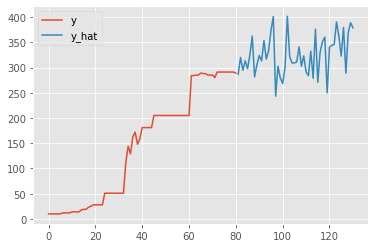

In [11]:
y_hat = esrnn.predict(X_test[['unique_id']])
X_plot = y_train.append(y_hat)
plot_id = 0
y_test_plot = X_plot.loc[X_plot['unique_id']==uniques[plot_id]]
plot_prediction(y_test_plot['y'], y_test_plot['y_hat'])

In [12]:
y_hat = esrnn.predict(X_test[['unique_id','ds','y']])

========= Predicting ESRNN =========



In [13]:
np.abs(y_hat['y_hat']-y_hat['y']).mean()

32.685025169735866